### Using a TRILEGAL file for a given healpix, 
### produce maps with Mr - [Fe/H] priors 

Version with a subsample of the hipscat TRILEGAL catalog processed with LSDB

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os
import numpy as np

cluster = SLURMCluster(
    cores=1,
    processes=1,
    memory="10GB",
    # n_workers=300,
    shebang='#!/usr/bin/env bash',
    queue="irb_slurm",
    walltime="00:30:00",
    log_directory="/mnt/beegfs/scratch/slurm_log/",
    scheduler_options={'port': 6818, 'host':'192.168.200.100', "dashboard_address": 41987}, 
    # local_directory='/mnt/beegfs/scratch/tmp',
    death_timeout="15s",
    # interface="bond0",
    # log_directory=f'{os.environ["SCRATCH_cecam"]}/{os.environ["USER"]}/dask_jobqueue_logs/',
    # project="ecam"
)

ModuleNotFoundError: No module named 'dask_jobqueue'

In [2]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/beegfs/scratch/slurm_log//dask-worker-%J.err
#SBATCH -o /mnt/beegfs/scratch/slurm_log//dask-worker-%J.out
#SBATCH -p irb_slurm
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH -t 00:30:00

/mnt/beegfs/scratch/lovro/miniforge3/envs/photod-distributed/bin/python -m distributed.cli.dask_worker tcp://192.168.200.100:6818 --name dummy-name --nthreads 1 --memory-limit 9.31GiB --nanny --death-timeout 15s



In [7]:
client = Client(cluster)
cluster.scale(50)
# cluster.wait_for_workers(50)

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://192.168.200.100:41987/status,
Dashboard: http://192.168.200.100:41987/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.200.100:6818,Workers: 0
Dashboard: http://192.168.200.100:41987/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
cluster.dashboard_link

'http://192.168.200.100:41987/status'

In [9]:
client.dump_cluster_state

<bound method Client.dump_cluster_state of <Client: 'tcp://192.168.200.100:6818' processes=0 threads=0, memory=0 B>>

In [10]:
try:
    client.shutdown()
    client.close()

except Exception as e:
    print(e)
    pass

In [2]:
%matplotlib inline
import sys
import healpy as hp
import hipscat
import hipscat_import
import pandas as pd
import numpy as np

from dask.distributed import Client

pd.set_option('display.max_columns', None)

## Run all

CPU times: user 48.3 s, sys: 26.5 s, total: 1min 14s
Wall time: 1min 30s


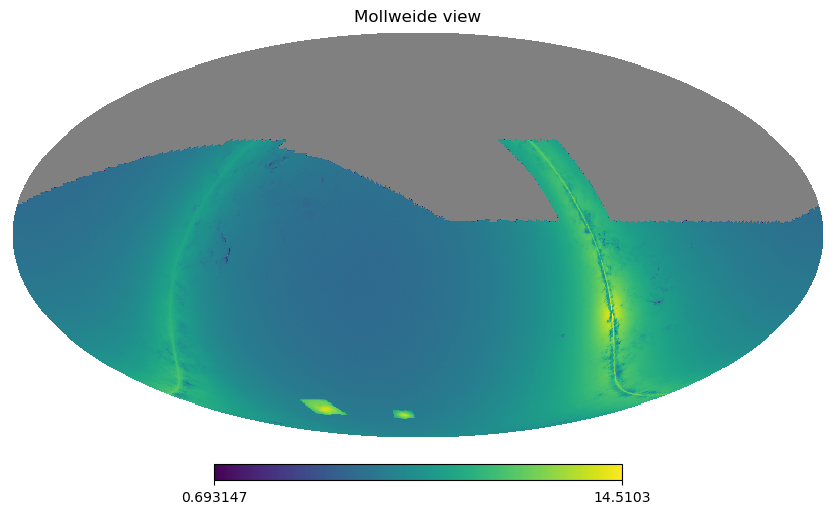

In [4]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
tril = lsdb.read_hipscat(tril_fn)
tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [ ]:
%%time
def prep(df, pix):
    sys.path.append('../src')
    import LocusTools as lt
    import BayesTools as bt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    importlib.reload(bt)
    importlib.reload(pt)

    rootname = '/mnt/beegfs/scratch/lovro/temp/hipscat_LSDB_sample'  # TODO: clean this up!
    df=df.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", "m_h": "FeH", "av": "Av",
                          "mu0": "DM"})
    trilegal = lt.readTRILEGALLSDB(df)
    trilegal['Mr'] = trilegal['rmag'] - trilegal['Ar'] - trilegal['DM']
    r = bt.dumpPriorMaps_testing(trilegal, rootname, pix, verbose=True)
    # return pd.DataFrame(data=[(len(trilegal), type(trilegal))], columns=['len', 'dtype']) # <--- it is expected that a Pandas is returned
    return pd.DataFrame(data=[(pix, len(trilegal))], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned

sys.path.append('../src')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

a = tril.map_partitions(prep, include_pixel=True).compute()

# Only one healpix is returned because the outputs are overwritten!!! Fix the file naming scheme! Fix the naming scheme


sample <class 'pandas.core.frame.DataFrame'>
Healpix:  Order: 0, Pixel: 0 
---------------------------------------
tS <class 'pandas.core.frame.DataFrame'>
r= 13.5 to 14.5 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 14.0 to 15.0 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 14.5 to 15.5 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 15.0 to 16.0 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 15.5 to 16.5 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 16.0 to 17.0 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 16.5 to 17.5 N= 0 Ns= 0
ERROR: no data to make map (see dumpPriorMaps)
tS <class 'pandas.core.frame.DataFrame'>
r= 17.0 to 18.0 N= 0 Ns= 0
ERROR: no da

In [ ]:
a

## Scratch space

In [77]:
np.unique(a, return_counts=True)

(array([ 112567,  210022,  696958,  776826,  881369,  981651, 1025168,
        1124530, 1124700, 1128361, 1156332, 1188914, 1225620, 1235248,
        1243232, 1274153, 1291534, 1304386, 1306199, 1308926, 1320731,
        1321482, 1322556, 1354994, 1363229, 1364280, 1369538, 1392237,
        1394393, 1398447, 1411293, 1415253, 1426034, 1426293, 1430631,
        1432275, 1439474, 1439766, 1451263, 1458690, 1461692, 1461877,
        1462039, 1485536, 1500820, 1526270, 1539761, 1540429, 1545774,
        1553521, 1574848, 1591254, 1597852, 1602623, 1608167, 1650935,
        1674982, 1678839, 1686230, 1697624, 1708304, 1721011, 1727258,
        1735063, 1736854, 1736929, 1786864, 1787314, 1790450, 1792276,
        1809054, 1819400, 1823405, 1826704, 1842392, 1853778, 1867267,
        1902173, 1903009, 1964546, 1964824, 1972536, 1977620, 1978571,
        1998702, 2005900, 2031561, 2057000, 2077249, 2094489, 2105637,
        2118274, 2133615, 2173366, 2200468, 2206254, 2242670, 2247902,
      

In [26]:
import pandas as pd
import numpy as np

# Creating random data
data = {
    'A': np.random.rand(10),
    'B': np.random.randint(0, 100, 10),
    'C': np.random.choice(['X', 'Y', 'Z'], 10)
}

# Creating DataFrame
df = pd.DataFrame(data)

print(df)

          A   B  C
0  0.342904  47  X
1  0.239746  36  Y
2  0.789822  64  Z
3  0.268605  87  Y
4  0.778181  29  Y
5  0.106068   3  X
6  0.851149  34  X
7  0.723695  43  Y
8  0.706385  14  X
9  0.184090  46  X


In [30]:
filts = (df["A"]>0.5) & (df["B"]<50)
filts

0    False
1    False
2    False
3    False
4     True
5    False
6     True
7     True
8     True
9    False
dtype: bool

In [34]:
%%timeit
df[filts]

50.9 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [35]:
%%timeit
df.iloc[filts.index]

50.3 µs ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
